In [2]:
# import os
# os.chdir('basenji')

## basenji
## ├── data
## │   └── MDA_MB_231_LM2.entire-gene.is-exon.dataset.required-cols.pkl
## ├── model.py
## ├── modules.py
## └── train-basenji.ipynb

In [3]:
import torch
import numpy as np
import pandas as pd
import random

# from models import Basenji
# from modules import Trainer
import models
import modules

%load_ext autoreload
%autoreload 2

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

random_seed = 2022
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)

num_threads = 4
torch.set_num_threads(num_threads)

In [5]:
data_path = 'data/MDA_MB_231_LM2.entire-gene.is-exon.dataset.required-cols.pkl'

In [6]:
param_vals = { 
    "mode": "regression", # "classification",
    "optimizer" : "Adam", 
    "init_lr": 0.001, 
    "optimizer_momentum": 0.9, 
    "weight_decay": 1e-3, 
    "loss": "binomial", # "bce",
    "loss_reduction": "mean",
    "num_targets": 1,
    "seq_len": 2**15, # 128*128*8,
    "min_seq_len": 2**12,
    "max_seq_len": 2**15,
    "target_window": 1024*32,
    "batch_size": 64, # 8
    "train_frac": 0.25, # "cut": 0.8,
    "val_frac": 0.05,
    "shuffle_data": False,
    "n_thres": 5,
    "num_workers": 4, # 8,
    "num_epochs": 100,
    "save_results": True
}

In [7]:
model = models.Basenji(debug=False, max_seq_len = param_vals['max_seq_len'])
model.compile(device)

init dsets
began training
102 21
Train Epoch: 0 [0/102 (0%)]	Loss: 23.417030	Rp: -0.104000	Rs: -0.063800	R2: -1.339400	MAE: 0.523400
11.0 35.75


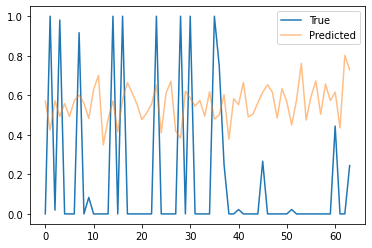

Train Epoch: 0 [10/102 (9%)]	Loss: 23.340221	Rp: 0.145300	Rs: 0.112500	R2: 0.016400	MAE: 0.173600
Train Epoch: 0 [20/102 (19%)]	Loss: 10.628269	Rp: 0.095500	Rs: 0.108600	R2: -0.123900	MAE: 0.236100
Train Epoch: 0 [30/102 (29%)]	Loss: 18.614273	Rp: -0.078700	Rs: -0.070300	R2: -0.116400	MAE: 0.219800
Train Epoch: 0 [40/102 (39%)]	Loss: 11.837884	Rp: 0.471500	Rs: 0.356700	R2: 0.034300	MAE: 0.221600
Train Epoch: 0 [50/102 (49%)]	Loss: 3.497428	Rp: -0.095500	Rs: 0.006400	R2: -0.134500	MAE: 0.260600
Train Epoch: 0 [60/102 (58%)]	Loss: 8.502332	Rp: 0.388400	Rs: 0.112900	R2: 0.047600	MAE: 0.185600
Train Epoch: 0 [70/102 (68%)]	Loss: 47.674625	Rp: 0.466900	Rs: 0.597100	R2: 0.109600	MAE: 0.106800
Train Epoch: 0 [80/102 (78%)]	Loss: 31.896862	Rp: 0.078400	Rs: 0.224400	R2: -0.041700	MAE: 0.185800
Train Epoch: 0 [90/102 (88%)]	Loss: 4.365197	Rp: 0.241500	Rs: 0.148900	R2: 0.038500	MAE: 0.219900
Train Epoch: 0 [100/102 (98%)]	Loss: 11.671177	Rp: 0.331400	Rs: 0.226300	R2: 0.058900	MAE: 0.265400
Valida

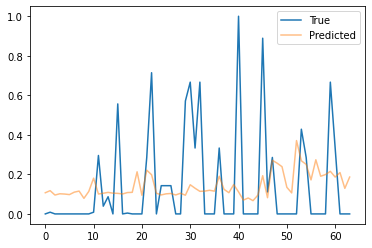

Validation Epoch: 0 [10/21 (47%)]	Loss: 5.127562	Rp: 0.281900	Rs: 0.196800	R2: 0.037300	MAE: 0.201000
Validation Epoch: 0 [20/21 (95%)]	Loss: 7.180743	Rp: 0.424400	Rs: 0.476600	R2: -0.037600	MAE: 0.266100


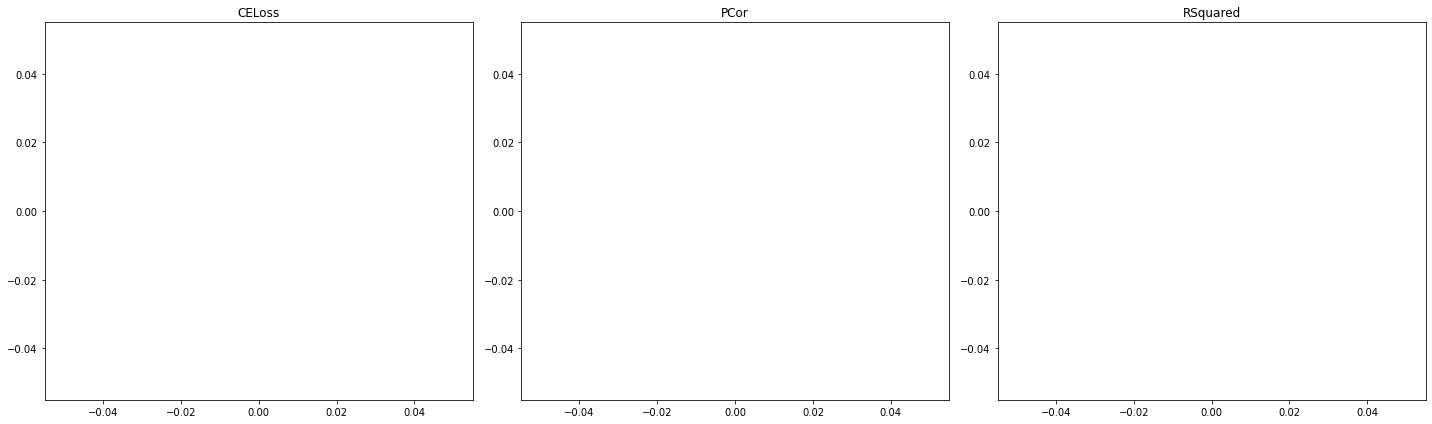

/mnt/c/Ali/saberi/splicing/splicing-env/lib/python3.8/site-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


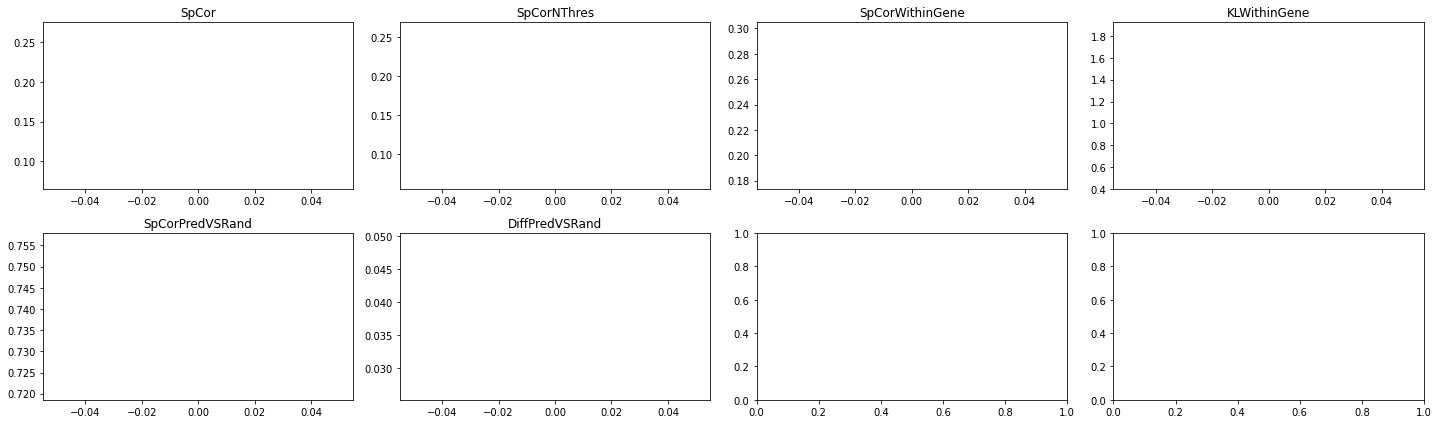

Saving model on epoch 0
102 21
Train Epoch: 1 [0/102 (0%)]	Loss: 10.112550	Rp: 0.343000	Rs: 0.354700	R2: 0.070800	MAE: 0.220300
11.0 7.859375


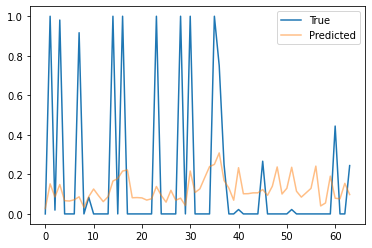

Train Epoch: 1 [10/102 (9%)]	Loss: 21.486496	Rp: 0.337400	Rs: 0.151000	R2: 0.081300	MAE: 0.155600
Train Epoch: 1 [20/102 (19%)]	Loss: 10.282224	Rp: 0.249900	Rs: 0.077300	R2: 0.060400	MAE: 0.155100
Train Epoch: 1 [30/102 (29%)]	Loss: 16.114496	Rp: 0.176600	Rs: 0.251000	R2: -0.042400	MAE: 0.210200
Train Epoch: 1 [40/102 (39%)]	Loss: 9.308940	Rp: 0.484000	Rs: 0.458000	R2: 0.187300	MAE: 0.214000


KeyboardInterrupt: 

In [9]:
trainer = modules.Trainer(param_vals, model, data_path)
trainer.train(debug=False)